In [384]:
import pandas as pd
from IPython.display import display
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix
import numpy as np
import seaborn as sns
import functools


In [385]:
class Metrics:
    @staticmethod
    def k_fold_cross_validation(x, y, k: int, x_column_names: list = None, y_column_names: list = None, folds_to_return: int = None):
        if k <= 0 or k > len(x):
            raise ValueError(
                "k must be greater than 0 and less than the number of rows in the dataset")

        if len(x) != len(y):
            raise ValueError(
                "The number of rows in the dataset must be equal to the number of rows in the expected output")

        if folds_to_return is None: 
            folds_to_return = k

        # Shuffle the dataset
        shuffled_dataset = list(zip(x, y))
        np.random.shuffle(shuffled_dataset)
        x, y = map(
            np.array, zip(*shuffled_dataset))

        fold_len = int(len(x) / k)
        folds = []

        # Split the dataset into k folds
        # Maybe we want less folds than k
        for i in range(min(k, folds_to_return)):
            x_test = x[i *
                       fold_len: (i + 1) * fold_len]
            y_test = y[i *
                       fold_len: (i + 1) * fold_len]

            x_train = np.concatenate(
                [x[:i * fold_len],
                 x[(i + 1) * fold_len:]])

            y_train = np.concatenate(
                [y[:i * fold_len],
                 y[(i + 1) * fold_len:]])

            # If df_columns is not None, then we need to create a dataframe for both sets
            if x_column_names is not None:
                x_train = pd.DataFrame(
                    x_train, columns=x_column_names)
                x_test = pd.DataFrame(
                    x_test, columns=x_column_names)
                y_train = pd.DataFrame(
                    y_train, columns=y_column_names)
                y_test = pd.DataFrame(
                    y_test, columns=y_column_names)

            # Load the test and train sets into the folds
            folds.append({
                'x_train': x_train,
                'y_train': y_train,
                'x_test': x_test,
                'y_test': y_test,
            })

        return folds

    @staticmethod
    def k_fold_cross_validation_eval(x, y, model, k: int, x_column_names: list = None, y_column_names: list = None):
        if model is None:
            raise ValueError("Model cannot be None")

        folds = Metrics.k_fold_cross_validation(
            x, y, k=k, x_column_names=x_column_names, y_column_names=y_column_names)

        # Evaluate the model on each fold
        results = []
        errors = []
        for fold in folds:
            # Train the model
            x_train = fold['x_train']
            y_train = fold['y_train']
            model.train(pd.concat([x_train, y_train], axis=1))

            # Evaluate the model on the test set
            x_test = fold['x_test']
            y_test = fold['y_test']
            predictions = model.test(pd.concat([x_test, y_test], axis=1))
            results.append(predictions)
            errors.append(Metrics.error(predictions, y_test, uses_df=x_column_names is not None))

        return results, errors

    @staticmethod
    def error(predictions, y, uses_df=False):
        if uses_df:
            predictions = predictions.values
            y = y.values

        return functools.reduce(
            lambda x, y: 0 if x == y else 1, list(zip(predictions, y)), 0) / len(predictions)


    @staticmethod
    def get_confusion_matrix(y, y_pred, labels=None):
        cf_matrix = confusion_matrix(y, y_pred, labels=labels)
        return pd.DataFrame(cf_matrix, index=labels, columns=labels)

    @staticmethod
    def plot_confusion_matrix_heatmap(cf_matrix):
        ax = sns.heatmap(cf_matrix, annot=True, cmap='Blues', fmt='d' )
        ax.set_xlabel('Predicted labels', fontsize=18)
        ax.set_ylabel('True labels', fontsize=18)
        plt.yticks(rotation=0)
        ax.xaxis.tick_top() # x axis on top
        ax.xaxis.set_label_position('top')
        plt.rcParams["figure.figsize"] = (8,6)
        plt.show()

    # https://arxiv.org/pdf/2008.05756#:~:text=Accuracy%20is%20one%20of%20the,computed%20from%20the%20confusion%20matrix.&text=The%20formula%20of%20the%20Accuracy,confusion%20matrix%20at%20the%20denominator.
    @staticmethod
    def get_tp_for_class(cf_matrix, label):
        return cf_matrix[label][label]

    @staticmethod
    def get_tn_for_class(cf_matrix, label):
        # Sum all values and subtract other metrics
        return cf_matrix.to_numpy().sum() - \
            (Metrics.get_tp_for_class(cf_matrix, label) + \
            Metrics.get_fp_for_class(cf_matrix, label) + \
            Metrics.get_fn_for_class(cf_matrix, label))

    @staticmethod
    def get_fp_for_class(cf_matrix, label):
        # Sum all rows except the label row
        return sum(cf_matrix.loc[:, label]) - cf_matrix[label][label]
    
    @staticmethod
    def get_fn_for_class(cf_matrix, label):
        # Sum all columns except the label column
        return sum(cf_matrix.loc[label, :]) - cf_matrix[label][label]

    @staticmethod
    def get_accuracy_for_class(cf_matrix, label):
        # (TP + TN) / (TP + TN + FP + FN)
        numerator = Metrics.get_tp_for_class(cf_matrix, label) + Metrics.get_tn_for_class(cf_matrix, label)
        denominator = numerator + Metrics.get_fp_for_class(cf_matrix, label) + Metrics.get_fn_for_class(cf_matrix, label) 
        return numerator / denominator

    @staticmethod
    def get_precision_for_class(cf_matrix, label):
        # TP / (TP + FP)
        numerator = Metrics.get_tp_for_class(cf_matrix, label)
        denominator = numerator + Metrics.get_fp_for_class(cf_matrix, label)
        return numerator / denominator

    @staticmethod
    def get_recall_for_class(cf_matrix, label):
        # TP / (TP + FN)
        numerator = Metrics.get_tp_for_class(cf_matrix, label)
        denominator = numerator + Metrics.get_fn_for_class(cf_matrix, label)
        return numerator / denominator

    @staticmethod
    def get_f1_score_for_class(cf_matrix, label):
        # 2 * Precision * Recall / (Precision + Recall)
        precision = Metrics.get_precision_for_class(cf_matrix, label)
        recall = Metrics.get_recall_for_class(cf_matrix, label)
        return 2 * precision * recall / (precision + recall)
    
    @staticmethod
    def tp_rate_for_class(cf_matrix, label):
        # TP / (TP + FN)
        return Metrics.get_recall_for_class(cf_matrix, label)

    @staticmethod
    def fp_rate_for_class(cf_matrix, label):
        # FP / (FP + TN)
        numerator = Metrics.get_fp_for_class(cf_matrix, label)
        denominator = numerator + Metrics.get_tn_for_class(cf_matrix, label)
        return numerator / denominator

    @staticmethod
    def get_metrics_per_class(cf_matrix):
        metrics = {}
        for label in cf_matrix.columns:
            metrics[label] = {
                'accuracy': Metrics.get_accuracy_for_class(cf_matrix, label),
                'precision': Metrics.get_precision_for_class(cf_matrix, label),
                'recall': Metrics.get_recall_for_class(cf_matrix, label),
                'f1-score': Metrics.get_f1_score_for_class(cf_matrix, label),
                'tp-rate': Metrics.tp_rate_for_class(cf_matrix, label),
                'fp-rate': Metrics.fp_rate_for_class(cf_matrix, label)
            }
        return metrics




In [386]:
class NaiveBayesTextClassifier():
    predicted_class_column_name = 'prediccion'

    def __init__(self, classes, text_column_name, classes_column_name, tokenizer):
        self.relative_frequencies = {}  # by_class_by_value
        self.classes_probabilities = {}
        self.classes = classes
        self.classes_column_name = classes_column_name
        self.text_column_name = text_column_name
        self.row_count_by_class = {}
        self.tokenizer = tokenizer

    def train(self, data_df):
        for c in self.classes:
            class_df = data_df[data_df[self.classes_column_name] == c]
            self.row_count_by_class[c] = len(class_df)
            self.classes_probabilities[c] = len(class_df) / len(data_df)

            values_appearances = {}
            # iterate over rows within class
            for i in range(len(class_df)):
                row = class_df.iloc[[i]]

                tokenized_text = self.tokenizer(
                    row[self.text_column_name].values[0])
                # iterate over values within row
                for token in tokenized_text:
                    # initialize possible value if not present in map, otherwise increment appereances
                    if token not in values_appearances:
                        values_appearances[token] = 1
                    else:
                        values_appearances[token] += 1

            # calculate relative frequencies
            self.relative_frequencies[c] = {token: (token_count + 1) / (len(class_df) + len(
                self.classes)) for token, token_count in values_appearances.items()}

    def classify(self, sample):
        tokenized_sample = self.tokenizer(sample)
        classification = {}

        maximizing_class = None
        maximizing_prod = -1
        for c in self.classes:

            prod = self.classes_probabilities[c]
            token_likelihoods = self.relative_frequencies[c]
            laplace_constant = 1 / \
                (self.row_count_by_class[c] + len(self.classes))

            for token in tokenized_sample:
                prod *= token_likelihoods[token] if token in token_likelihoods else laplace_constant

            classification[c] = prod

        return dict(sorted(classification.items(), key=lambda item: item[1], reverse=True))

    def test(self, test_df):
        predicted_classes = []
        expected_classes= []

        for i in range(len(test_df)):
            row = test_df.iloc[[i]]
            row_class = row[self.classes_column_name].values[0]

            classification = self.classify(
                row[self.text_column_name].values[0])
            predicted_class = max(classification, key=classification.get)

            predicted_classes.append(predicted_class)
            expected_classes.append(row_class)

        # append results column to new dataframe
        results_df = test_df.copy()
        results_df[self.predicted_class_column_name] = predicted_classes
        results_df[self.classes_column_name] = expected_classes

        return results_df

    def get_evaluation_metrics_by_class(self, test_results_df):
        pass

    def plot_roc_curve(self):
        pass


In [387]:
def tokenize(text: str):
    return text.split()


In [388]:
data_df = pd.read_csv("./Noticias_argentinas.txt", header=0, sep='\t')
classes = ["Economia", "Salud", "Ciencia y Tecnologia", "Deportes"]

data_df = data_df[data_df["categoria"].isin(classes)]

nbclassifier = NaiveBayesTextClassifier(
    classes, "titular", "categoria", tokenize)

y = data_df.loc[:, ["categoria"]]
x = data_df.loc[:, ["titular"]]


In [389]:
# K-fold cross validation
# results, errors = Metrics.k_fold_cross_validation_eval(x.values.tolist(), y.values.tolist(
# ), model=nbclassifier, x_column_names=x.columns, y_column_names=y.columns, k=5)
# print(errors)

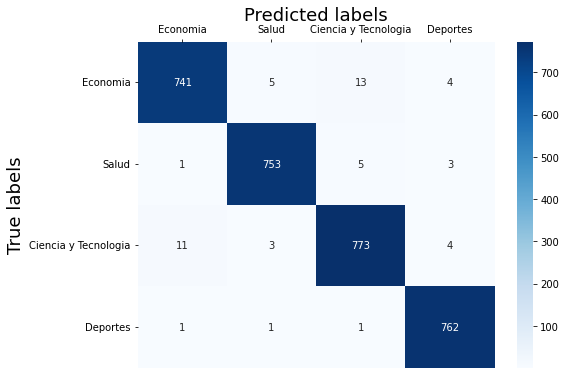

                      Economia  Salud  Ciencia y Tecnologia  Deportes
Economia                   741      5                    13         4
Salud                        1    753                     5         3
Ciencia y Tecnologia        11      3                   773         4
Deportes                     1      1                     1       762
{'Economia': {'accuracy': 0.9886400519311912, 'precision': 0.9827586206896551, 'recall': 0.9711664482306684, 'f1-score': 0.976928147659855, 'tp-rate': 0.9711664482306684, 'fp-rate': 0.0056082830025884385}, 'Salud': {'accuracy': 0.994157740993184, 'precision': 0.9881889763779528, 'recall': 0.9881889763779528, 'f1-score': 0.9881889763779528, 'tp-rate': 0.9881889763779528, 'fp-rate': 0.0038809831824062097}, 'Ciencia y Tecnologia': {'accuracy': 0.987990912041545, 'precision': 0.976010101010101, 'recall': 0.97724399494311, 'f1-score': 0.9766266582438408, 'tp-rate': 0.97724399494311, 'fp-rate': 0.008296943231441048}, 'Deportes': {'accuracy': 0.9954

In [390]:
# Get train and test sets
folds = Metrics.k_fold_cross_validation(x.values.tolist(), y.values.tolist(), x_column_names=x.columns, y_column_names=y.columns, k=5, folds_to_return=1)
train = pd.concat([folds[0]['x_train'], folds[0]['y_train']], axis=1)
test = pd.concat([folds[0]['x_test'], folds[0]['y_test']], axis=1)

# Train the model
nbclassifier.train(train)

# Test the model
results = nbclassifier.test(test)

# Get evaluation metrics

# Get confusion matrix
confusion_matrix = Metrics.get_confusion_matrix(
    results[nbclassifier.classes_column_name].values.tolist(), results[nbclassifier.predicted_class_column_name].values.tolist(), labels=nbclassifier.classes)
Metrics.plot_confusion_matrix_heatmap(confusion_matrix)
print(confusion_matrix)

# Get evaluation metrics by class
evaluation_metrics = Metrics.get_metrics_per_class(confusion_matrix)
print(evaluation_metrics)


# train_set = data_df.sample(frac=0.8, random_state=1)
# print("======================")
# print(train_set.index)
# test_set = data_df.drop(train_set.index)

# nbclassifier.train(train_set)
# print(nbclassifier.test(test_set))

# sample_columns = data_df.columns.drop("categoria")

# print(nbclassifier.classify("Histórico: Los Pumas derrotaron por primera vez a los All Blacks en Nueva Zelanda"))
# print(nbclassifier.classify("Maradona negó haber criticado a Messi, disparó otra vez contra Scaloni y también la ligó Solari"))
# print(nbclassifier.classify("Guzmán"))